# Installing libraries
- Installing the fastai library through fastbook
- Force reinstalling Kaggle API. Doing this because of a warning from the Kaggle API that the existing library preinstalled is outdated. This is the solution based on [this stackoverflow post](https://stackoverflow.com/questions/58643979/google-colaboratory-use-kaggle-server-version-1-5-6-client-version-1-5-4-fai).

In [1]:
!pip install -Uqq fastbook
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 727kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 10.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 204kB 21.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=7b10b608502320c3318e8151646b5430fe0b42fed2f4ce47a13fbcb0ce92f8cb
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import shutil
from PIL import Image

from fastai.vision.all import *
from fastai.vision.widgets import *

from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


# Importing Datasets from Kaggle

## Setting Kaggle Credentials
Make sure to put your Kaggle credentials in a Google Drive folder. Here, that Google Drive folder is named `kaggle_credentials`. Details on getting your Kaggle credentials `json` file [found here](https://www.kaggle.com/docs/api) under the Authentication header.

In [3]:
creds_filename = "kaggle.json"
colab_creds_folder = f"{os.environ['HOME']}/.kaggle"
gdrive_creds_folder = "drive/MyDrive/kaggle_credentials"

if not os.path.exists(colab_creds_folder):
  os.mkdir(colab_creds_folder)


shutil.copy(f"{gdrive_creds_folder}/{creds_filename}", f"{colab_creds_folder}/{creds_filename}")

'/root/.kaggle/kaggle.json'

## Downloading the datasets

We'll be using the [plant pathology datasets](https://www.kaggle.com/c/plant-pathology-2020-fgvc7). Documentation on using the Kaggle API are [found here](https://www.kaggle.com/docs/api). It's better to download straight from Kaggle so we don't use up our Google Drive space.

In [4]:
!kaggle competitions download -c plant-pathology-2020-fgvc7
!unzip -q plant-pathology-2020-fgvc7.zip
!rm plant-pathology-2020-fgvc7.zip

100% 777M/779M [00:10<00:00, 38.5MB/s]
100% 779M/779M [00:10<00:00, 78.6MB/s]


In [5]:
os.listdir()

['.config',
 'drive',
 'sample_submission.csv',
 'images',
 'train.csv',
 'test.csv',
 'sample_data']

In [6]:
images_folderpath = Path("images")
images_folderpath.ls()

(#3642) [Path('images/Train_1042.jpg'),Path('images/Test_214.jpg'),Path('images/Test_927.jpg'),Path('images/Test_56.jpg'),Path('images/Train_1643.jpg'),Path('images/Test_660.jpg'),Path('images/Train_538.jpg'),Path('images/Train_1115.jpg'),Path('images/Train_1081.jpg'),Path('images/Train_320.jpg')...]

## Preparing Training and Test Sets

In [7]:
train_df = pd.read_csv("train.csv")
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB
None


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [8]:
# checking if there's only 1 label per row
assert all(train_df.drop(columns = "image_id").sum(axis = 1) == 1)

In [9]:
label_names = ["healthy", "multiple_diseases", "rust", "scab"]

def get_label(row, label_names = label_names):
  classified_labels = []
  for label in label_names:
    if row[label] == 1:
      return label

  raise ValueError(f"Row {row} has invalid labels! Please recheck")
  return -1

train_df["label"] = train_df.apply(get_label, axis = 1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
strsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

idx_train, idx_valid = next(strsplit.split(train_df["image_id"], train_df["label"]))

## this is entirely random split
# idx_valid = np.random.choice(train_df.index, size = int(train_df.shape[0]*0.2))

train_df["is_valid"] = train_df.index.isin(set(idx_valid))
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label,is_valid
0,Train_0,0,0,0,1,scab,False
1,Train_1,0,1,0,0,multiple_diseases,False
2,Train_2,1,0,0,0,healthy,False
3,Train_3,0,0,1,0,rust,True
4,Train_4,1,0,0,0,healthy,True


In [11]:
# checking class distribution, it should be split evenly
foo = train_df.groupby(["is_valid","label"])["label"].count().unstack()
foo.apply(lambda row: row/row.sum(), axis = 1)

label,healthy,multiple_diseases,rust,scab
is_valid,,,,
False,0.283654,0.050137,0.341346,0.324863
True,0.282192,0.049315,0.342466,0.326027


### Setting Class Weights
This is for oversampling the minority class and for adjusting the loss function to be more sensitive to the minority class.

In [12]:
from sklearn.utils.class_weight import compute_class_weight
labels = ["healthy",	"multiple_diseases",	"rust",	"scab"]

class_weights = compute_class_weight("balanced", labels, train_df["label"])
class_weights = pd.Series(class_weights, labels)

## alternative class weights that's simply based on 1/count
#class_weights = 1/train_df["label"].value_counts().reindex(labels)

class_weights

healthy              0.882267
multiple_diseases    5.002747
rust                 0.731913
scab                 0.769003
dtype: float64

In [13]:
class_weights_dict = class_weights.to_dict()
class_weights_dict

{'healthy': 0.8822674418604651,
 'multiple_diseases': 5.002747252747253,
 'rust': 0.7319131832797428,
 'scab': 0.7690033783783784}

In [14]:
train_df["class_weight"] = train_df["label"].map(class_weights_dict)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label,is_valid,class_weight
0,Train_0,0,0,0,1,scab,False,0.769003
1,Train_1,0,1,0,0,multiple_diseases,False,5.002747
2,Train_2,1,0,0,0,healthy,False,0.882267
3,Train_3,0,0,1,0,rust,True,0.731913
4,Train_4,1,0,0,0,healthy,True,0.882267


In [15]:
test_df = pd.read_csv("test.csv")
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB
None


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


## Creating DataLoaders

In [16]:
initial_size = 460
final_size = 224
bs = 64

def get_y(row):
  return row["label"]

def get_x(row, images_folderpath = images_folderpath):
  return images_folderpath/f"{row['image_id']}{'.jpg'}"

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter(col = "is_valid"),
                   get_y=get_y, 
                   get_x=get_x,
                   item_tfms=Resize(initial_size),
                   batch_tfms=[*aug_transforms(size=final_size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

## alternative dataloader that uses class weights
# wgts = train_df.loc[~train_df["is_valid"],"class_weight"]
# dls = dblock.dataloaders(train_df, bs = bs, wgts = wgts, dl_type = WeightedDL,
#                          shuffle_train = True, drop_last = True)

dls = dblock.dataloaders(train_df, bs = bs)

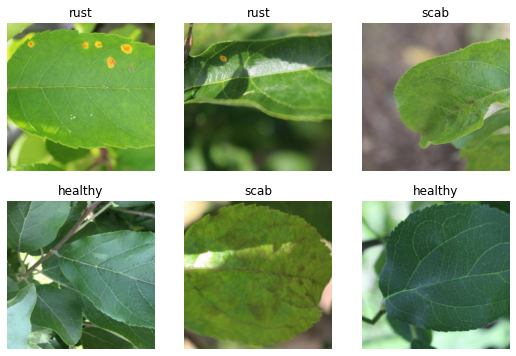

In [17]:
dls.show_batch(nrows = 2, ncols = 3, unique = False)

## Including ROC Metrics

These average ROC score is the metric of the competition

In [18]:
# ROC metrics taken from Lex's notebook kernel
def comp_metric(preds, targs, labels=range(4)):
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_auc(*args):
    return comp_metric(*args, labels=[0])

def mult_diseases_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_auc(*args):
    return comp_metric(*args, labels=[3])


metrics_list = [accuracy,
              AccumMetric(healthy_auc, flatten=False),
              AccumMetric(mult_diseases_auc, flatten=False),
              AccumMetric(rust_auc, flatten=False),
              AccumMetric(scab_auc, flatten=False),
              AccumMetric(comp_metric, flatten=False)
                ]

## Training the Model

In [19]:
## alternative loss function that uses class weights so loss function is more senstive to minority class
#loss_func = CrossEntropyLossFlat(weight = torch.cuda.FloatTensor(class_weights))

loss_func = CrossEntropyLossFlat()
loss_func

FlattenedLoss of CrossEntropyLoss()

In [20]:
learn = cnn_learner(dls, resnet34, metrics = metrics_list, loss_func = loss_func)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Minimum/10: 1.45e-02, steepest point: 3.63e-03


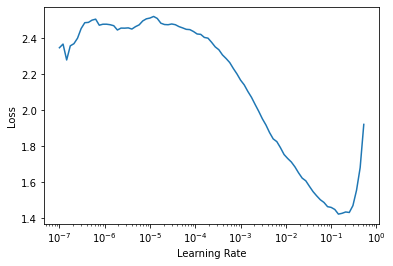

In [21]:
# finding an initial learning rate
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [22]:
base_lr = 1e-2
learn.fine_tune(5, base_lr = base_lr)

epoch,train_loss,valid_loss,accuracy,healthy_auc,mult_diseases_auc,rust_auc,scab_auc,comp_metric,time
0,1.219118,0.870810,0.802740,0.949196,0.627602,0.965233,0.948965,0.872749,01:17


epoch,train_loss,valid_loss,accuracy,healthy_auc,mult_diseases_auc,rust_auc,scab_auc,comp_metric,time
0,0.535346,0.528068,0.871233,0.984103,0.681716,0.991567,0.975200,0.908146,01:19
1,0.438746,0.449619,0.860274,0.954903,0.596542,0.983233,0.960443,0.873780,01:18
2,0.324792,0.287200,0.904110,0.963981,0.705251,0.992900,0.987737,0.912467,01:18
3,0.254041,0.272936,0.928767,0.992737,0.660583,0.996033,0.986848,0.909050,01:17
4,0.197271,0.230736,0.939726,0.993108,0.725264,0.996100,0.988283,0.925689,01:18


## Interpreting the Model

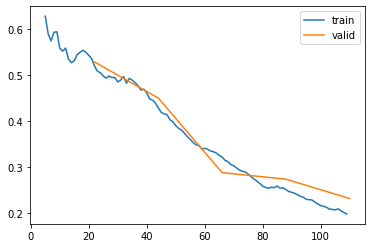

In [23]:
learn.recorder.plot_loss()

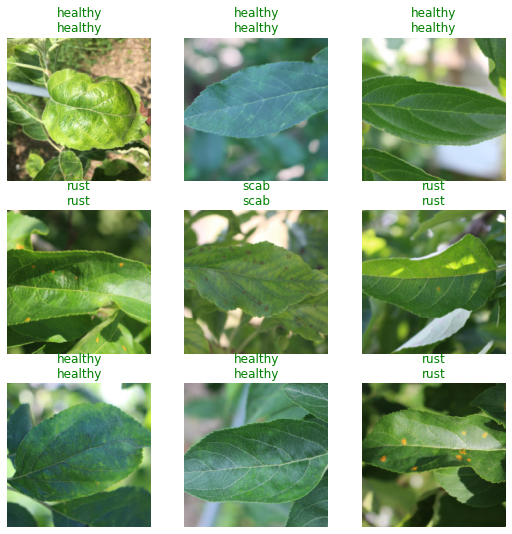

In [24]:
learn.show_results()

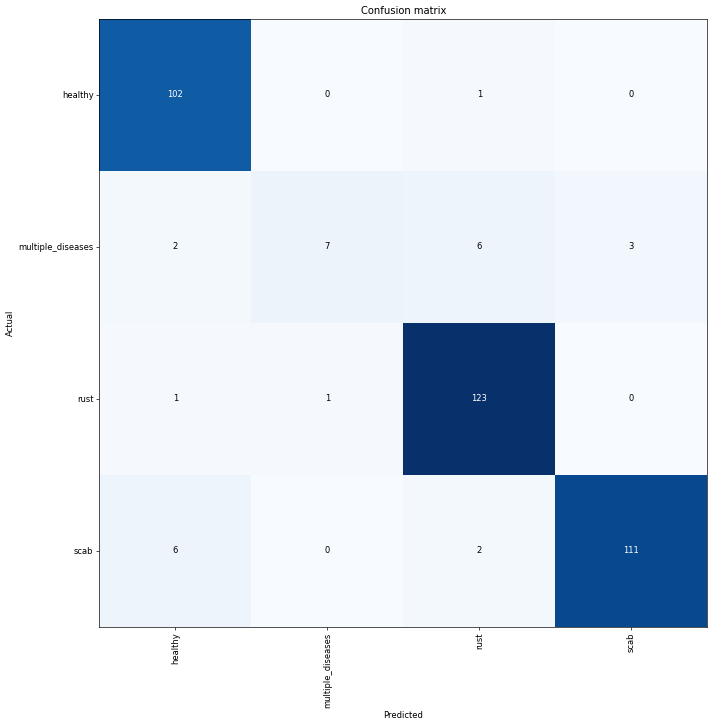

In [25]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused()

[('multiple_diseases', 'rust', 6),
 ('scab', 'healthy', 6),
 ('multiple_diseases', 'scab', 3),
 ('multiple_diseases', 'healthy', 2),
 ('scab', 'rust', 2),
 ('healthy', 'rust', 1),
 ('rust', 'healthy', 1),
 ('rust', 'multiple_diseases', 1)]

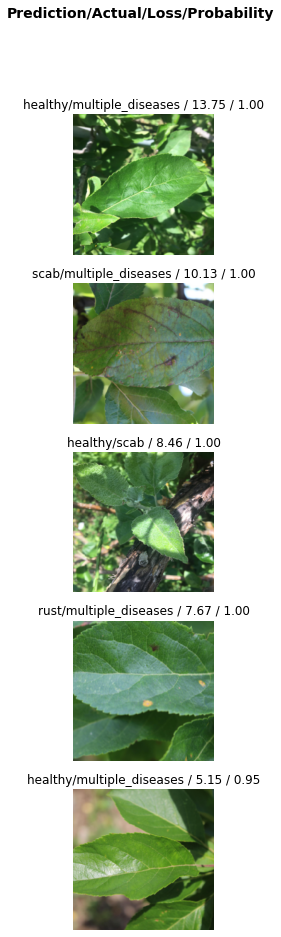

In [27]:
interp.plot_top_losses(5, nrows = 5, ncols = 1)

## Saving the Model

In [28]:
model_filepath = "plant_pathology_model.pkl"
learn.export(model_filepath)

## Predicting on Test Set

In [29]:
learn = load_learner(model_filepath)

In [30]:
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [31]:
test_img_paths = [images_folderpath/f"{img_id[0]}.jpg" for img_id in test_df.values]
test_dl = learn.dls.test_dl(test_img_paths)

In [32]:
%%time
preds, _ = learn.get_preds(dl = test_dl)

## test time augmentation takes longer but improvement is very marginal
#preds, _ = learn.tta(dl = test_dl)

CPU times: user 4min 26s, sys: 2.48 s, total: 4min 28s
Wall time: 4min 37s


In [33]:
test_df = pd.DataFrame(preds.numpy(), columns = dls.vocab, index = test_df["image_id"]).reset_index()
test_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,9.848141e-06,3.438563e-04,9.996462e-01,1.023893e-07
1,Test_1,1.091517e-06,7.245616e-04,9.992735e-01,8.002729e-07
2,Test_2,5.173561e-07,5.890906e-05,5.264867e-12,9.999405e-01
3,Test_3,9.998883e-01,3.573258e-07,8.664773e-05,2.469204e-05
4,Test_4,9.326473e-07,2.501640e-03,9.974968e-01,5.379833e-07


## Submitting Predictions to Kaggle

In [35]:
test_df.to_csv("submission.csv", index = False)

In [36]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f submission.csv -m "submission"

100% 105k/105k [00:02<00:00, 44.9kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7